# 동시구매 상품분석 실습

## 1. 환경 설정 

### 1.1 분석에 필요한 library 호출 및 google drive 연결


In [36]:
# apriori  패키지 다운로드 및 설치 for 연관성 분석 
!pip install mlxtend --upgrade

In [39]:
## 1. 분석에 사용할 패키지 로딩
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn as sk

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules,fpgrowth

#apriori : 큰 데이터(메모리 클떄) 사용

구글드라이브에 있는 데이터셋 연결을 위한 구글드라이브 세팅
from google.colab import drive
drive.mount('/content/drive')

## 2. 데이터 불러오기 및 확인

### 2.1 데이터 불러오기 및 확인

In [3]:
data = pd.read_csv('data.csv', encoding= 'unicode_escape')

data.head()

## invoice 동일 = 한번에 구매  = 한 영수증에 구매
## 유저별 단위가 아니기때문에 CustomerID 필요 없음

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
data.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


In [5]:
#매번 까먹지 말고 확인하기!
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
# 2.3 데이터형변환
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data.info()

#invoiceNo 가 같으면 같이 구매했음을 의미

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## 3. Null값 확인 및 처리

### 3..1 Null 값 확인

In [8]:
# 3.1 Null 값이 있는 전체 case 수 확인
print(data.isnull().sum().sum())

136534


In [9]:
# Null 값이 있는 변수별 요약 (null 값이 있는 컬럼이 2개 존재)
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
# 혹시 "" 공란으로 비어 있는 값이 있나 확인 -> 없음
data[data['Description']==''] 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


(array([3.30e+03, 2.35e+02, 8.30e+01, 3.40e+01, 3.00e+01, 2.00e+01,
        7.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([1.0000e+00, 1.1230e+02, 2.2360e+02, 3.3490e+02, 4.4620e+02,
        5.5750e+02, 6.6880e+02, 7.8010e+02, 8.9140e+02, 1.0027e+03,
        1.1140e+03]),
 <BarContainer object of 10 artists>)

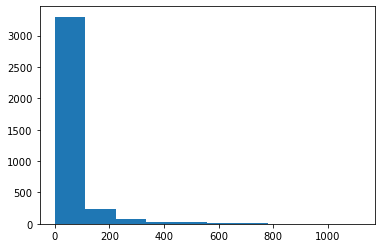

In [11]:
# CustomerID Null 값인과 정상 거래 트랜잭션 별 상품수 확인 
## 비회원들이 인보이스별 몇개의 상품을 구매하는지 확인
data_null = data[data.CustomerID.isnull()].groupby('InvoiceNo')['StockCode'].count()
plt.hist(data_null)

(array([2.0858e+04, 1.1410e+03, 1.4500e+02, 2.5000e+01, 6.0000e+00,
        3.0000e+00, 5.0000e+00, 2.0000e+00, 2.0000e+00, 3.0000e+00]),
 array([  1. ,  55.1, 109.2, 163.3, 217.4, 271.5, 325.6, 379.7, 433.8,
        487.9, 542. ]),
 <BarContainer object of 10 artists>)

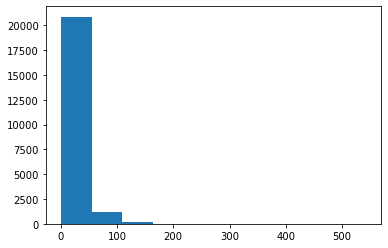

In [12]:
# 회원들이 인보이스별 구매하는 분포 확인
data_notnull = data[data.CustomerID.notnull()].groupby('InvoiceNo')['StockCode'].count()
plt.hist(data_notnull)

In [13]:
# Description NA 값 확인 및 처리 
# 상품 정보를 확인할 수 있는 Description이 Null 인 것만 분석에서 제외 
# 연관성 분석의 기준은 CustomerID 기준이 아니라 InvoiceNo 기준이라 CustomerID 값이 Null 인것도 사용함
data_na_treat = data[data.Description.notnull()]
data_na_treat.describe()

,Quantity,UnitPrice,CustomerID
count,540455.000000,540455.000000,406829.000000
mean,9.603129,4.623519,15287.690570
std,218.007598,96.889628,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


회원 거래와 비회원 거래 의 분포가 비슷함을 알 수 있음 !

## 4. 데이터 탐색 및 이상치 제거
### 4.1 이상치 확인 


In [14]:
# Quantity 이상치 case 확인
data_na_treat[(data_na_treat.Quantity == 80995) | (data_na_treat.Quantity == -80995)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom


In [15]:
# 음수 -> 환불 확인
data_na_treat[(data_na_treat.Quantity <= 0) & (data_na_treat.InvoiceNo.astype(str).str[0] == 'C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [16]:
# 환불 데이터는 InvoiceNo 앞에 "C"로 표시 &  Quantity 값이 음수(-)
data_pur = data_na_treat[data_na_treat.InvoiceNo.astype(str).str[0] != 'C']
data_pur.describe()

,Quantity,UnitPrice,CustomerID
count,531167.000000,531167.000000,397924.000000
mean,10.293623,3.858153,15294.315171
std,159.301358,41.814651,1713.169877
min,-9600.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13969.000000
50%,3.000000,2.080000,15159.000000
75%,10.000000,4.130000,16795.000000
max,80995.000000,13541.330000,18287.000000


In [17]:
# 분석 단위 확인을 위한 트랜잭션 당 구매 상품수 확인
data_pur.groupby('InvoiceNo')['StockCode'].count().describe()

count    20610.000000
mean        25.772295
std         47.001377
min          1.000000
25%          6.000000
50%         15.000000
75%         29.000000
max       1114.000000
Name: StockCode, dtype: float64

In [19]:
#  유저별로 얼마나 많이 주문을 했나 ? 유저별 거래수(트랜잭션)
data_pur.groupby('CustomerID')['InvoiceNo'].nunique().describe()

count    4339.000000
mean        4.271952
std         7.705493
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       210.000000
Name: InvoiceNo, dtype: float64

In [18]:
# 유저별로 하루에 거래한 횟수(하루에 몇번 주문?)
## 인보이스 별로 분석해도 무리 없음
data_pur['dt'] = pd.to_datetime(data_pur['InvoiceDate']).dt.date
data_pur.groupby(['CustomerID','dt'])['InvoiceNo'].nunique().describe()

C:\Users\Miyoung\AppData\Local\Temp\ipykernel_17124\1186831832.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pur['dt'] = pd.to_datetime(data_pur['InvoiceDate']).dt.date


count    16766.000000
mean         1.105571
std          0.444950
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         24.000000
Name: InvoiceNo, dtype: float64

In [20]:
# 유저별로 몇개의 상품을 전체기간동안 주문했는지 확인
data_pur.groupby('CustomerID')['StockCode'].nunique().describe()

count    4339.000000
mean       61.489283
std        85.363900
min         1.000000
25%        16.000000
50%        35.000000
75%        77.000000
max      1787.000000
Name: StockCode, dtype: float64

In [21]:
# InvoiceNo 단위로도 충분함 !!
data_invoice_cnt = data_pur.groupby('InvoiceNo').agg(
    n = ('StockCode','count'))
data_invoice_cnt.columns = ['n']
data_invoice_cnt

,n
InvoiceNo,
536365,7
536366,2
536367,12
536368,4
536369,1
...,...
581586,4
581587,15
A563185,1


(0.0, 100.0)

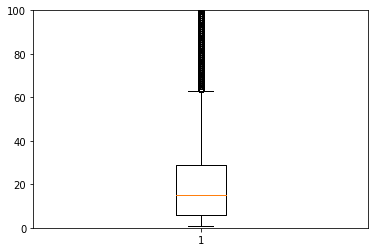

In [22]:
# 이상치 제거  (한번에 너무 많은 상품을 구매하는 InvoiceNo 제거 )
# 이상치 기준 탐색
fig, ax = plt.subplots()
ax.boxplot(data_invoice_cnt)
ax.set_ylim (0,100)

In [64]:
# 이거 다시 봐야함(2번 과제 참고)
#np.percentile(data_invoice_cnt, 0.01)
#data_invoice_cnt.quantile(q=0.99,  interpolation='nearest')

In [23]:
print("mean: %s, sd: %s, two_sigma: %s" % (data_invoice_cnt.mean(), data_invoice_cnt.std(), data_invoice_cnt.mean()+2*data_invoice_cnt.std()))

mean: n    25.772295
dtype: float64, sd: n    47.001377
dtype: float64, two_sigma: n    119.775049
dtype: float64


In [28]:
data_invoice_cnt.describe()

,n
count,20610.000000
mean,25.772295
std,47.001377
min,1.000000
25%,6.000000
50%,15.000000
75%,29.000000
max,1114.000000


In [30]:
#이상치 제거 데이터(2-sigma 기준으로 함)
outlier_treat = data_invoice_cnt[(data_invoice_cnt.n >= 2)  & (data_invoice_cnt.n <= 120)] # 2인이유?
pur_outlier_treat = pd.merge(outlier_treat, data_pur, how ='inner', on = 'InvoiceNo' )
pur_outlier_treat

,InvoiceNo,n,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,dt
0,536365,7,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,7,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,7,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,7,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,7,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
...,...,...,...,...,...,...,...,...,...,...
395212,581587,15,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-09
395213,581587,15,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-09
395214,581587,15,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09
395215,581587,15,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09


## 5. 데이터 변환 및 데이터 탐색 
### 5.1 연관성 분석용 matrix 생성

In [31]:
pur_by_tran = pur_outlier_treat[['InvoiceNo', 'Description']] # invoice 와 description 뽑음

def toList(x):
    return list(set(x)) 

purchase_list = pur_by_tran.groupby('InvoiceNo')['Description'].apply(lambda x: toList(x)).reset_index()
purchase_list = list(purchase_list.Description)
purchase_list[:5]

#각 유저별 invoice 당 구매한 디스크립션 리스트

[['WHITE METAL LANTERN',
  'RED WOOLLY HOTTIE WHITE HEART.',
  'KNITTED UNION FLAG HOT WATER BOTTLE',
  'SET 7 BABUSHKA NESTING BOXES',
  'WHITE HANGING HEART T-LIGHT HOLDER',
  'CREAM CUPID HEARTS COAT HANGER',
  'GLASS STAR FROSTED T-LIGHT HOLDER'],
 ['HAND WARMER RED POLKA DOT', 'HAND WARMER UNION JACK'],
 ['BOX OF VINTAGE ALPHABET BLOCKS',
  'LOVE BUILDING BLOCK WORD',
  'ASSORTED COLOUR BIRD ORNAMENT',
  "POPPY'S PLAYHOUSE KITCHEN",
  'BOX OF 6 ASSORTED COLOUR TEASPOONS',
  'RECIPE BOX WITH METAL HEART',
  "POPPY'S PLAYHOUSE BEDROOM ",
  'HOME BUILDING BLOCK WORD',
  'IVORY KNITTED MUG COSY ',
  'DOORMAT NEW ENGLAND',
  'BOX OF VINTAGE JIGSAW BLOCKS ',
  'FELTCRAFT PRINCESS CHARLOTTE DOLL'],
 ['JAM MAKING SET WITH JARS',
  'BLUE COAT RACK PARIS FASHION',
  'RED COAT RACK PARIS FASHION',
  'YELLOW COAT RACK PARIS FASHION'],
 ['SPACEBOY LUNCH BOX ',
  'MINI PAINT SET VINTAGE ',
  'STARS GIFT TAPE ',
  ' SET 2 TEA TOWELS I LOVE LONDON ',
  'CHARLOTTE BAG DOLLY GIRL DESIGN',
  'CIRCUS

In [32]:
# 유저별 구매 디스크립션을 매트릭스형태로 변형
te = TransactionEncoder()
te_ary = te.fit(purchase_list).transform(purchase_list)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17798,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17799,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17800,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
17801,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## 5.2 EDA #####
### 데이터 탐색

<AxesSubplot:>

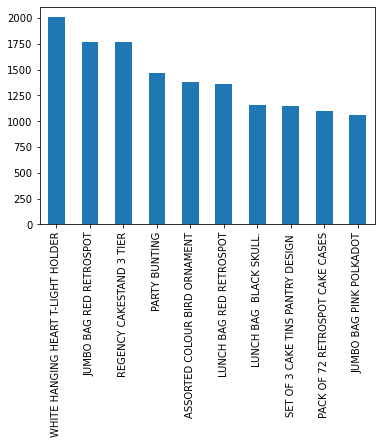

In [33]:
# 가장 많이 구매항 상품 top 10
fig, ax = plt.subplots()
pur_outlier_treat['Description'].value_counts().head(10).plot(ax=ax, kind='bar')

In [34]:
pur_outlier_treat['Description'].value_counts(normalize =True) #.plot(ax=ax, kind='bar')
#support 값 -> 'normalize= True'

WHITE HANGING HEART T-LIGHT HOLDER    0.005083
JUMBO BAG RED RETROSPOT               0.004484
REGENCY CAKESTAND 3 TIER              0.004471
PARTY BUNTING                         0.003712
ASSORTED COLOUR BIRD ORNAMENT         0.003497
                                        ...   
ANTIQUE OPAL WHITE FLOWER EARRINGS    0.000003
SET OF 4 KNICK KNACK TINS  DOILEY     0.000003
FUNKY MONKEY MUG                      0.000003
SET 10 CARDS HANGING BAUBLES 17080    0.000003
NEW BAROQUE B'FLY NECKLACE GREEN      0.000003
Name: Description, Length: 3901, dtype: float64

## 6. 모델링 #####
### 6.1연관성 모델 생성

In [35]:
freq_itemsets1 = apriori(df, min_support = 0.01, max_len = 3, use_colnames = True)
freq_itemsets1

,support,itemsets
0,0.012751,( SET 2 TEA TOWELS I LOVE LONDON )
1,0.013369,(10 COLOUR SPACEBOY PEN)
2,0.014380,(12 PENCIL SMALL TUBE WOODLAND)
3,0.016402,(12 PENCILS SMALL TUBE RED RETROSPOT)
4,0.015728,(12 PENCILS SMALL TUBE SKULL)
...,...,...
1097,0.011122,"(LUNCH BAG WOODLAND, LUNCH BAG SUKI DESIGN , L..."
1098,0.014323,"(REGENCY CAKESTAND 3 TIER, PINK REGENCY TEACUP..."
1099,0.010392,"(POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE ..."
1100,0.012863,"(WOODLAND CHARLOTTE BAG, STRAWBERRY CHARLOTTE ..."


In [40]:
## 용량이 클경우, fpgrowth 로 사용 !(단, mixtend 업그레이드 버전에 포함되어있어서, 최신버전 업글후에 import 하기!)
freq_itemsets1 = fpgrowth(df, min_support = 0.01, max_len = 3, use_colnames = True)
freq_itemsets1

,support,itemsets
0,0.109701,(WHITE HANGING HEART T-LIGHT HOLDER)
1,0.020558,(RED WOOLLY HOTTIE WHITE HEART.)
2,0.020446,(KNITTED UNION FLAG HOT WATER BOTTLE)
3,0.016626,(SET 7 BABUSHKA NESTING BOXES)
4,0.013649,(WHITE METAL LANTERN)
...,...,...
1097,0.010448,"(LUNCH BAG VINTAGE DOILY , LUNCH BAG BLACK SK..."
1098,0.012077,"(JUMBO BAG VINTAGE DOILY , LUNCH BAG VINTAGE D..."
1099,0.011627,"(LOVE HOT WATER BOTTLE, HOT WATER BOTTLE KEEP ..."
1100,0.013706,"(CHOCOLATE HOT WATER BOTTLE, HOT WATER BOTTLE ..."


In [41]:
from mlxtend.frequent_patterns import fpgrowth
fpgrowth(df, min_support=0.5, use_colnames=True)

,support,itemsets


### 6.2 생성된 연관성 규칙 확인  #####

In [42]:
## antecedents 선형변수 consequents 후행변수 -> 앞에꺼를 샀을 경우에 뒤에꺼를 살 확률
## 보통 리프트 중심으로 체크
rules_conf_20 = association_rules(freq_itemsets1, metric='confidence', min_threshold=0.5) #0.5% 이상
rules_conf_20.sort_values(['lift'],ascending = False).head(10)
# rules = association_rules(freq_itemsets1, metric='lift', min_threshold=1)
# rules.sort_values(['lift'], ascending=False).head(10) 

##pink 의 서포트 = 0.012 , green 의 서포트 = 0.14 -> pink & green 의 서포트 : 0.01 -> pink 산사람이 green 구매 : 0.89 -> 
## 단순 green 사는 것 대비,  pink샀을때 green 살 확률이 61배 올라간다

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
398,(REGENCY TEA PLATE PINK),(REGENCY TEA PLATE GREEN ),0.012077,0.014492,0.010841,0.897674,61.943014,0.010666,9.631101
399,(REGENCY TEA PLATE GREEN ),(REGENCY TEA PLATE PINK),0.014492,0.012077,0.010841,0.748062,61.943014,0.010666,3.921296
393,(REGENCY MILK JUG PINK ),(REGENCY SUGAR BOWL GREEN),0.015278,0.014773,0.011627,0.761029,51.515615,0.011402,4.122797
392,(REGENCY SUGAR BOWL GREEN),(REGENCY MILK JUG PINK ),0.014773,0.015278,0.011627,0.787072,51.515615,0.011402,4.624675
267,"(POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE ...",(POPPY'S PLAYHOUSE LIVINGROOM ),0.014099,0.014548,0.010392,0.737052,50.663062,0.010186,3.747703
272,(POPPY'S PLAYHOUSE LIVINGROOM ),"(POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE ...",0.014548,0.014099,0.010392,0.714286,50.663062,0.010186,3.450654
400,(REGENCY TEA PLATE PINK),(REGENCY TEA PLATE ROSES ),0.012077,0.017750,0.010616,0.879070,49.525567,0.010402,8.122453
401,(REGENCY TEA PLATE ROSES ),(REGENCY TEA PLATE PINK),0.017750,0.012077,0.010616,0.598101,49.525567,0.010402,2.458140
268,"(POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE ...",(POPPY'S PLAYHOUSE BEDROOM ),0.011852,0.018368,0.010392,0.876777,47.734757,0.010174,7.966324
271,(POPPY'S PLAYHOUSE BEDROOM ),"(POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE ...",0.018368,0.011852,0.010392,0.565749,47.734757,0.010174,2.275524


In [44]:
rules_conf_20.sort_values(['confidence'], ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
316,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.025164,0.041454,0.022637,0.899554,21.700206,0.021593,9.542861
398,(REGENCY TEA PLATE PINK),(REGENCY TEA PLATE GREEN ),0.012077,0.014492,0.010841,0.897674,61.943014,0.010666,9.631101
310,"(REGENCY CAKESTAND 3 TIER, PINK REGENCY TEACUP...",(GREEN REGENCY TEACUP AND SAUCER),0.016683,0.041454,0.014717,0.882155,21.280492,0.014025,8.133950
400,(REGENCY TEA PLATE PINK),(REGENCY TEA PLATE ROSES ),0.012077,0.017750,0.010616,0.879070,49.525567,0.010402,8.122453
269,"(POPPY'S PLAYHOUSE BEDROOM , POPPY'S PLAYHOUSE...",(POPPY'S PLAYHOUSE KITCHEN),0.011852,0.018929,0.010392,0.876777,46.318295,0.010167,7.961765
268,"(POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE ...",(POPPY'S PLAYHOUSE BEDROOM ),0.011852,0.018368,0.010392,0.876777,47.734757,0.010174,7.966324
72,"(SET/20 RED RETROSPOT PAPER NAPKINS , SET/6 RE...",(SET/6 RED SPOTTY PAPER PLATES),0.012020,0.019884,0.010504,0.873832,43.945839,0.010265,7.768325
278,"(CHARLOTTE BAG PINK POLKADOT, STRAWBERRY CHARL...",(RED RETROSPOT CHARLOTTE BAG),0.015110,0.044543,0.013032,0.862454,19.362245,0.012358,6.946430
311,"(REGENCY CAKESTAND 3 TIER, PINK REGENCY TEACUP...",(ROSES REGENCY TEACUP AND SAUCER ),0.016683,0.046060,0.014323,0.858586,18.640737,0.013555,6.745721
314,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.026737,0.046060,0.022637,0.846639,18.381351,0.021405,6.220214


In [45]:
# 결과 csv로 저장
df_csv = pd.DataFrame(rules_conf_20)
df_csv.to_csv('association_rule_result.csv',index=False) 

In [ ]:
# 실제 비즈니스 상황에서는 카테고리로 묶기 or 제품별로 묶기 -> supoort 값과 lift 값이 올라감!